In [43]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [44]:
tsla_df = pd.read_csv("./docs/Homework3 - TSLA.csv")
tesla_data = tsla_df
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)
tesla_data.sort_index(inplace=True)
tesla_data = tesla_data[:2950]

# Split data into training and testing sets (70% train, 30% test)
train_size = int(len(tesla_data) * 0.7)
train_data = tesla_data[:train_size]
test_data = tesla_data[train_size:]

train_data = train_data["Close"].tolist()
test_data = test_data["Close"].tolist()

In [105]:
def to_sequences(SEQUENCE_SIZE, obs):
    x = []
    y = []

    for i in range(len(obs) - SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i + SEQUENCE_SIZE)]
        after_window = obs[i + SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)

    return np.array(x), np.array(y)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

SEQUENCE_SIZE = 60
x_train, y_train = to_sequences(SEQUENCE_SIZE, train_data)
x_test, y_test = to_sequences(SEQUENCE_SIZE, test_data)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (2005, 60, 1)
Shape of test set: (825, 60, 1)


In [46]:
from tensorflow import keras
from tensorflow.keras import layers


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [47]:

def build_model(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [48]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

callbacks = [keras.callbacks.EarlyStopping(patience=10,
                                           restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)


Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 823.5414 - val_loss: 1619.4576
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 462.1706 - val_loss: 617.0887
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 222.8789 - val_loss: 191.8254
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 134.7649 - val_loss: 67.9796
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 137.4419 - val_loss: 35.6785
Epoch 6/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 116.2284 - val_loss: 22.4367
Epoch 7/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 117.2654 - val_loss: 18.7432
Epoch 8/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 111.0773 - val_loss: 17.7262
Epoch 9/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 103.4479 - val_loss: 17.6728
Epoch 10/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 123.6142 - val_loss: 18.0759
Epoch 11/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 100.2048 - val_loss: 18.1884
Epoch 12/200
26

In [49]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ input_layer_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 10, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 10, 1)     │          0 │ dropout_27[0][0], │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 10, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 10, 4)     │          0 │ conv1d_16[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 10, 1)     │          5 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 10, 1)     │          0 │ conv1d_17[0][0],  │
│                     │                   │            │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 10, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 10, 1)     │          0 │ dropout_30[0][0], │
│                     │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 10, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 10, 4)     │          0 │ conv1d_18[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 10, 1)     │          5 │ dropout_31[0][0]

 Total params: 90,845 (354.87 KB)

 Trainable params: 30,281 (118.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,564 (236.58 KB)

In [50]:
from sklearn import metrics

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Score (RMSE): 41.66410743104953


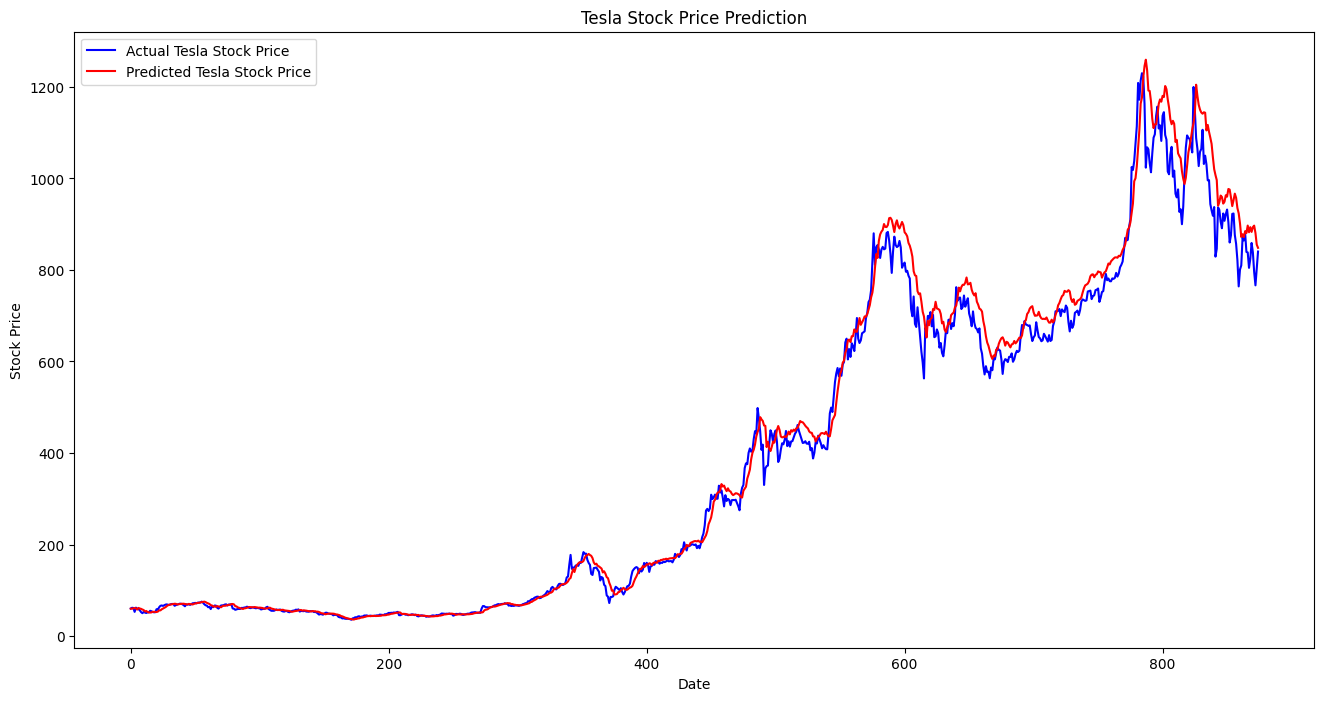

In [51]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(y_test, color='blue', label='Actual Tesla Stock Price')
plt.plot(pred, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [159]:
# Load gold price data
gold_data = pd.read_csv('./docs/gold.csv')
gold_data.sort_values('Date', inplace=True)
gold_data['Date'] = pd.to_datetime(gold_data['Date'])

In [160]:
combined = pd.merge(tesla_data, gold_data, on='Date', how='inner')
combined_data = np.array(combined[[ 'Close_x', 'Close_y']])
# combined_data = combined[['Close_x', 'Close_y']]

In [161]:
# Normalize combined data
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_combined_data = scaler.fit_transform(combined_data[['Close_x', 'Close_y']])

In [162]:
# Prepare the dataset for LSTM
def create_dataset_with_gold(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]  # Use 'Close' and 'Gold' prices
        X.append(a)
        Y.append(dataset[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(Y)

In [163]:
X, Y = create_sequences(combined_data, SEQUENCE_SIZE)

In [164]:
print("Shape of training set: {}".format(X.shape))
print("Shape of test set: {}".format(Y.shape))

Shape of training set: (2818, 60, 2)
Shape of test set: (2818, 2)


In [165]:
# Split the data into training and testing sets (70% training, 30% testing)
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

In [166]:
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (1972, 60, 2)
Shape of test set: (846, 60, 2)


In [167]:
from tensorflow import keras
from tensorflow.keras import layers


def transformer_encoder_with_gold(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [168]:
def build_model_with_gold(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder_with_gold(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    # Added the first Dense layer
    x = layers.Dense(128, activation="relu")(x)  # Added this line
    x = layers.Dropout(mlp_dropout)(x)           # Added this line
    
    outputs = layers.Dense(2)(x)
    return keras.Model(inputs, outputs)

In [169]:
input_shape = x_train.shape[1:]

model_with_gold = build_model_with_gold(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_with_gold.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

callbacks = [keras.callbacks.EarlyStopping(patience=10,
                                           restore_best_weights=True)]

model_with_gold.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=callbacks,
)


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 265ms/step - loss: 816441.9375 - val_loss: 526998.8750
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - loss: 612754.3750 - val_loss: 370986.7812
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - loss: 427451.0312 - val_loss: 239232.8281
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - loss: 286976.7812 - val_loss: 139190.9531
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - loss: 190358.0625 - val_loss: 68574.3047


In [170]:
model_with_gold.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 60, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 2)     │          4 │ input_layer_14[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 2)     │     11,266 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_163         │ (None, 60, 2)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_98 (Add)        │ (None, 60, 2)     │          0 │ dropout_163[0][0… │
│                     │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 2)     │          4 │ add_98[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_98 (Conv1D)  │ (None, 60, 4)     │         12 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_164         │ (None, 60, 4)     │          0 │ conv1d_98[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_99 (Conv1D)  │ (None, 60, 2)     │         10 │ dropout_164[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_99 (Add)        │ (None, 60, 2)     │          0 │ conv1d_99[0][0],  │
│                     │                   │            │ add_98[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 2)     │          4 │ add_99[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 2)     │     11,266 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_166         │ (None, 60, 2)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_100 (Add)       │ (None, 60, 2)     │          0 │ dropout_166[0][0… │
│                     │                   │            │ add_99[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 2)     │          4 │ add_100[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_100 (Conv1D) │ (None, 60, 4)     │         12 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_167         │ (None, 60, 4)     │          0 │ conv1d_100[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_101 (Conv1D) │ (None, 60, 2)     │         10 │ dropout_167[0][0

 Total params: 187,016 (730.54 KB)

 Trainable params: 62,338 (243.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 124,678 (487.03 KB)

In [171]:

from sklearn import metrics

pred = model_with_gold.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Score (RMSE): {}".format(score))

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
Score (RMSE): 519.0674369888761


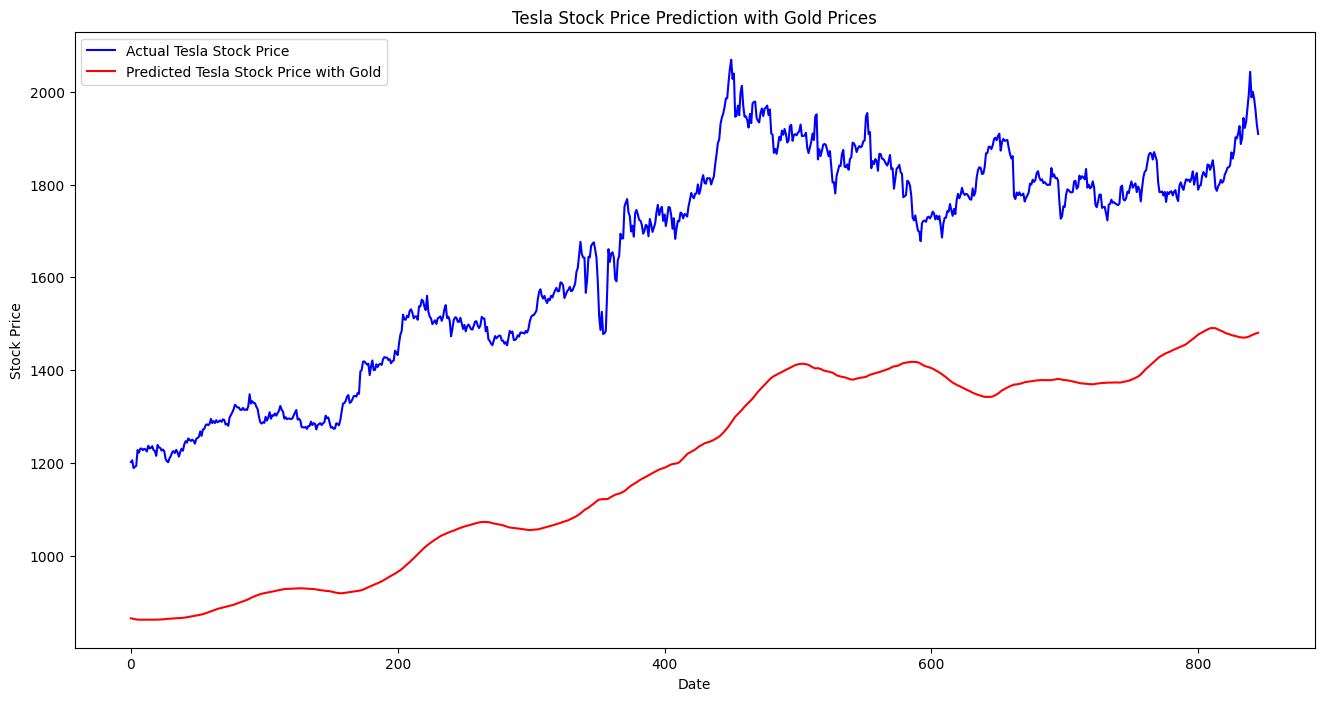

In [172]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(y_test[:,1], color='blue', label='Actual Tesla Stock Price')
plt.plot(pred[:,1], color='red', label='Predicted Tesla Stock Price with Gold')
plt.title('Tesla Stock Price Prediction with Gold Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()